# 7.2 Applying EKF for doing SLAM - The Shopping Malls Chain

The managers at Nirvana Shopping Mall have been very pleased with the results of our previous collaboration, and they desire to introduce more of our robots in the rest of their chain of shopping malls. Brilliant!. 

<br /><br />
<center>
<img src="./images/shopping-malls-logo.png">
</center>
<br />

Unfortunately, the system we provided for knowing the exact location of the robot at each time instant is too expensive for its replication, so we have to replace it by a system able to yield the robot position only relying on odometry and sensor observations. 

In this way, the managers are going to pay well for a number of robots able to attend and guide their visitors through a selected locations or *landmarks*. For that, **we have to design robots with the needed algorithms to build maps of their shopping malls as well as to localize themselves within that maps**. In other words, we have to endow them with a Simultaneous Localization and Mapping (SLAM) system.

## 7.2.1 Formalizing the problem

In the **online SLAM** problem, the state is defined by the robot pose as well as the position of the landmarks in the map, that is:

$$s_k=[x_k | m_{x1}, m_{y1}, \cdots ,m_{xL}, m_{yL}]^T = [x_k | \mathbf{m}]^T \ \ \ \ \ dim(s_k)=3+2L $$ 

being:
- $x_k$: the robot pose $[x,y,\theta]$.
- $\mathbf{m}$: landmarks of the map $[m_x,m_y]$.
- $L$: Number of landmarks.

Since the robot doesn't know the total number of landmarks, $s_k$ augments in $[m_x, m_y]$ every time a new landmark is observed.

The **Extended Kalman Filter (EKF) algorithm** was originally one of the most influential approaches to the online SLAM problem. We are going to employ it to fulfill the managers assignment, being its application here similar to the one we took to the problems of *localization* and *mapping*.

As usual, for being able to use EKF we assume that $s_k$ follows a Gaussian distribution, that is $s_k \sim N(\mu_{s_k},\Sigma_k)$, where: <br /><br />
$$\Sigma_k = \begin{bmatrix}
\Sigma_{x_k} & \Sigma_{xm_k} \\
\Sigma_{xm_k}^T & \Sigma_{m_k} \\
\end{bmatrix}_{(3+2L) \times (3+2L)}
$$
being:
- $\Sigma_{x_k}$: Covariance of the robot pose. Dimensions: $3x3$.
- $\Sigma_{xm_k}$: Correlation between pose and landmarks. Dimensions: $3x2L$. *Note: correlation means that error in $x_k$ affects error in $\mathbf{m}$, that is, the pose is unknown and produces a correlation between it and the observed landmarks.* 
- $\Sigma_{m_k}$: Covariance of the landmarks. Dimensions: $2Lx2L$.


**Example**

The following image is an example of the execution of EKF SLAM for estimating the robot pose and the map (landmark positions) while performing motion commands and observing those landmarks:

<figure style="text-align:center">
  <img src="images/fig7-1-1.png" alt="">
  <figcaption>
      Fig. 1: Execution of the EKF algorithm for SLAM. <br/>
      it shows 3 poses: true (blue), expected (red) and estimated (green + confidence ellipse); <br/>
      true landmarks (big multicolored squares), and 
      their final <br/> estimations (green squares + red confidence ellipse)
  </figcaption>
</figure>

## 7.2.2 Developing the EKF filter for doing SLAM

In [10]:
%matplotlib widget

import time
import math

import numpy as np
from numpy import random
from scipy import linalg
import matplotlib
#matplotlib.use('TkAgg')
from matplotlib import pyplot as plt
import pandas as pd
from IPython.display import display, clear_output
import time

import sys
sys.path.append("..")
from utils.tcomp import tcomp
from utils.Jacobians import J1, J2
from utils.DrawRobot import DrawRobot
from utils.PlotEllipse import PlotEllipse
from utils.AngleWrap import AngleWrap
from utils.unit7.FOV import FOVSensor
from utils.unit7.Jacobians import GetNewFeatureJacs, GetObsJacs
from utils.unit7.MapCanvas import MapCanvas
from utils.unit7.Robot import EFKSlamRobot

### The provided tools

Our coworkers at **<span style="color:seagreen">UMA-MR</span>** have developed two modules to facilitate our coding (if the links doesn't work for you, open them manually, they are placed at ``utils/unit7/``):

- [FOVSensor](/edit/utils/unit7/FOV.py): Take a look at the parameters it contains and its functions. 


- [EFKSlamRobot](/edit/utils/unit7/Robot.py): We'll only use its parameters (described below) and the step function, which carries out a motion command. Parameters: 
  - ``self.pose``: ideal robot pose without noise.
  - ``self.true_pose``: real (nosiy) robot pose.
  - ``self.cov_move``: Covariance associated with the robot motion ($\Sigma_{u}$).
  - ``self.xEst``: Estimated robot pose and map ($s_k$).
  - ``self.PEst``: Estimated uncertainty associated with the state ($\Sigma_k$).
  - ``self.MappedFeatures``: : A vector with length equal to the number of landmarks in the map ($L$), which elements can take the following values:
    - ``-1`` if the landmark with that index has not been seen yet.
    - ``[idx_in_xEst, idx_in_xEst+2]``:A vector indicating the first and last position of that landmark in ``xEst``.


### The prediction step

In the SLAM case, only the robot pose changes in the prediction step (the map is static), and we take the mean as the best estimate available. Thereby, the prediction step of EKF consists of the estimation of the new state and its associated uncertainty as:

$$
  \begin{aligned}
      \verb!def !& \verb!ExtendedKalmanFilter!(\mu_{s_{k-1}},\Sigma_{k-1}, u_k, \Sigma_u, z_k): \\
      & \textbf{Prediction.} \\
      & \bar\mu_{s_k} = \begin{bmatrix} \bar x_k \\ \bar m_k \end{bmatrix}= g(\mu_{s_{k-1}}, u_k) = \begin{bmatrix} x_{k-1} \oplus u_k  \\ m_{k-1} \end{bmatrix} &\text{(1. Pose and map prediction)}\\
      & \bar\Sigma_k = \frac{\partial g}{\partial s_{k-1}} \Sigma_{k-1} \frac{\partial g}{\partial s_{k-1}}^T + \frac{\partial g}{\partial u_k} \Sigma_{u_k} \frac{\partial g}{\partial u_k}^T &\text{(2. Uncertainty of prediction)} 
        \\
  \end{aligned}
$$

### **<span style="color:green"><b><i>ASSIGNMENT 1: Let's do predictions!</i></b></span>** 

Complete the method in the following cell to do the prediction step of the EKF filter.

Hint: Take a look at ``PPred`` and how it is built.

In [29]:
def prediction_step(xVehicle, xMap, robot, u):
    """ Performs the prediction step of the EKF algorithm for SLAM
    
        Args:
            xVehicle: Current estimation of the robot pose.
            xMap: Current estimation of the map (landmark positions)
            robot: Robot model.
            u: Control action. 
        
        Returns: Nothing. But it modifies the state in robot
            xPred: Predicted position of the robot and the landmarks
            PPred: Predicted uncertainty of the robot pose and landmarks positions
    """    
    xVehiclePred = tcomp(xVehicle,u)

    j1 = J1(xVehicle,u)
    j2 = J2(xVehicle,u)

    PPredvv = j1 @ robot.PEst[0:3,0:3] @ j1.T + j2 @ robot.cov_move @ j2.T
    PPredvm = j1 @ robot.PEst[0:3,3:]
    PPredmm = robot.PEst[3:,3:]

    xPred = np.vstack([xVehiclePred,xMap])
    PPred = np.vstack([
        np.hstack([PPredvv, PPredvm]),
        np.hstack([PPredvm.T, PPredmm])
    ])
    
    return xPred, PPred

### Observing a landmark for first time

As in the mapping case, when the sensor onboard the robot detects a landmark for the first time, there is no need to do the EKF update step (indeed, since there is not previously knowledge about the landmark, there is nothing to update). Instead, we have to properly modify the state vector and its associated uncertainties to accommodate this new information:

- **Modifying the state vector**: Insert the position of the landmark, using the sensor measurement $z_k=[r_k,\theta_k]$, at the end of the vector containing the estimated positions ``xEst``, so:
$$xEst=[x,y,\theta, x_1,y_y, \cdots, x_M, y_M, x_{M+1}, y_{M+1}]$$<br />
Since the measurement is provided in polar coordinates in the robot local frame, it has to be first converted to cartesians and then to the world frame using the robot pose $[x_v,y_v]'$:

$$ 
f(x_v,z_k)=\begin{bmatrix} x_{M+1} \\ y_{M+1} \end{bmatrix} =
\begin{bmatrix} x_v \\ y_v \end{bmatrix} + 
r_k\begin{bmatrix} cos \alpha_k \\ sin \alpha_k \end{bmatrix}
, \ \ \alpha_k = \theta_k + \theta_v
$$

- **Extending the covariance matrix**. In order to acomodate the uncertainty regarding the position of the new landmark, we have to extend the covariance matrix in the following way:
$$
PEst=\begin{bmatrix}
    [\Sigma_{x_{k-1}}]_{3 \times 3} & [\Sigma_{x_{k-1}m_1}]_{3 \times 2} & \cdots & [\Sigma_{x_{k-1}m_{M+1}}]_{3 \times 2} \\
    [\Sigma_{x_{k-1}m_1}]_{2 \times 3}^T & [\Sigma_{m_1}]_{2 \times 2} & \cdots & 0 \\
    \vdots & \vdots & \ddots & \vdots \\
    [\Sigma_{x_{k-1}m_{M+1}}]^T_{2 \times 3} & 0 & \cdots & [\Sigma_{m_{M+1}}]_{2 \times 2}
  \end{bmatrix}_{3+2n \times 3+2n}
  $$   
Notice that the covariances: <br /><br />
  - $\Sigma_{m_{M+1}}$ stands for the uncertainty in the measurement expressed in the world cartesian coordinates, retrieved by: <br /><br />
$$
\Sigma_{m_{M+1}} = J_z \Sigma_{{r\theta}_{M+1}} J_z^T
$$ <br />
being $\Sigma_{{r\theta}_{M+1}}$ the uncertainty characterizing the sensor measurements (``sensor.cov_sensor`` in our code), and $J_z$ (``jGz`` in our code) the jacobian of the function $f(x_v,z_k)$ that expresses the measurement in the robot local coordinates, which is: <br /><br />
$$
J_z =  \begin{bmatrix} \partial x / \partial r  &  \partial x / \partial \theta \\ \partial y / \partial r & \partial y / \partial \theta \end{bmatrix} =
\begin{bmatrix} cos \alpha & -r sin \alpha \\ sin \alpha & r cos \alpha \end{bmatrix}
$$ <br />
  - $ \Sigma_{x_{k-1}m_{M+1}}$ represents the correlation between the robot pose and the new observed landmark. Since the function $f_2(\cdot)$ for computing the landmark position in the map using the robot pose is:
  $$ f_2(x_v,z_k) = \begin{bmatrix} x_l \\ y_l \end{bmatrix} = 
  \begin{bmatrix}
      x_v + r \cos(\alpha) \\
      y_v + r \sin(\alpha)
  \end{bmatrix}  
  $$
  then such covariance matrix is retrieved by:
  $$
  \Sigma_{x_{k-1}m_{M+1}} = (J_v \Sigma_{x_{k-1}} )^T
  $$
  with $J_v$ (``jGxv`` in the code):
  $$
  J_v = \begin{bmatrix} 1 & 0 & -r \sin(\alpha) \\ 0 & 1 & r \cos(\alpha) \end{bmatrix}
  $$

### **<span style="color:green"><b><i>ASSIGNMENT 2: Incorporating a new landmark.</i></b></span>** 

Since these operations are quite similar to the ones that we carried out in the mapping case, our coworkers also provided us the ``GetNewFeaturesJacs()`` method that return these jacobians. You just have to complete the information related to the landmark, and wisely choose the position of the jacobians when building the ``M`` matrix, and auxiliary matrix to conveniently build the extended covariance matrix (``robot.Pest``).

In [12]:
def incorporate_new_landmark(robot, sensor, xPred, xVehicle, z, iLandmark):
    
    xVehiclePred = xPred[0:3]
    nStates = len(robot.xEst)

    xLandmark = (
                xVehiclePred[0:2] + 
                np.vstack([
                    z[0]*np.cos(z[1]+xVehiclePred[2]),
                    z[0]*np.sin(z[1]+xVehiclePred[2])
                ])
            )
    
    robot.xEst = np.vstack([xPred,xLandmark]) #augmenting state vector
    jGxv, jGz = GetNewFeatureJacs(xVehicle,z)
            
    M = np.vstack([
        np.hstack([np.eye(nStates), np.zeros((nStates,2))]),# note we don't use jacobian w.r.t vehicle
        np.hstack([jGxv, np.zeros((2,nStates-3)), jGz]),
        ])
    robot.PEst = M@linalg.block_diag(robot.PEst,sensor.cov_sensor)@M.T

    #remember this landmark as being mapped we store its ID and position in the state vector
    robot.MappedFeatures[iLandmark,:] = [len(robot.xEst)-2, len(robot.xEst)]


### The correction (update) step

Once a previously observed landmark is perceived by the robot, such observation can be use to correct the predictions made by EKF and refine the variables in the state (robot pose and landmarks' positions):

$$
  \begin{aligned}     
      & \textbf{Correction.} \\
      & K_k = \bar\Sigma_k H^T_k (H_k \bar\Sigma_k H^T_k + Q_k)^{-1} &\text{(3. Kalman gain)}\\
      & \mu_{s_k} = \bar \mu_{s_k} + K_k (z_k - h(\bar \mu_{s_k})) &\text{(4. Map estimation)}\\
      & \Sigma_k = (I - K_k H_k) \bar\Sigma_k &\text{(5. Uncertainty of estimation)}\\
      & \verb!return ! \mu_{s_k}, \Sigma_k
  \end{aligned}
$$

Recall that $Q_t$ models the uncertainty coming from the sensor observations, having dimensions $2M \times 2M$, and that $z_k$ stands for the observation taken by the sensor at time instant $k$. $H_k$ stands for the jacobian of the observation, which is defined as: <br /><br />
$$
H_k = \frac{\partial h(s_k)}{\partial s_k} = 
\begin{bmatrix}
\frac{\partial h_r}{\partial x_k} & \frac{\partial h_r}{\partial y_k} & \frac{\partial h_r}{\partial \theta_k} & | & \frac{\partial h_r}{\partial m_{x_1}} & \frac{\partial h_r}{\partial m_{y_1}} & \cdots & \frac{\partial h_r}{\partial m_{x_L}} & \frac{\partial h_r}{\partial m_{y_L}} \\
\frac{\partial h_\theta}{\partial x_k} & \frac{\partial h_\theta}{\partial y_k} & \frac{\partial h_\theta}{\partial \theta_k} & | & \frac{\partial h_\theta}{\partial m_{x_1}} & \frac{\partial h_\theta}{\partial m_{y_1}} & \cdots & \frac{\partial h_\theta}{\partial m_{x_L}} & \frac{\partial h_\theta}{\partial m_{y_L}}
\end{bmatrix} 
$$<br />
The first 3 columns of $H_k$ correspond to the jacobian w.r.t. the robot pose, which is defined as:<br /><br />
$$
jHxv = \begin{bmatrix} -\frac{x_i-x}{r} & -\frac{y_i -y}{r} & 0 \\ \frac{y_i-y}{r^2} & -\frac{x_i-x}{r^2} & -1 \end{bmatrix}
$$<br />
while the remaining pair of columns are associated with the observed landmarks, and take the values (for each landmark):<br /><br />
$$
jHxf = \begin{bmatrix} \frac{x_i-x}{r} & \frac{y_i -y}{r} \\ -\frac{y_i-y}{r^2} & \frac{x_i-x}{r^2} \end{bmatrix} \text{if observed, } jHxf = \begin{bmatrix} 0 & 0 \\ 0 & 0 \end{bmatrix}  \text{if not observed.}
$$

### **<span style="color:green"><b><i>ASSIGNMENT 3: It's time to update</i></b></span>** 

The following method partially implements the update step. **You are tasked to**:

- Build the state Jacobian $H_k$ (``jH`` in the code) used in such a step when a previously perceived landmark is seen again. Employ for that the output of the `GetObsJacs` function. 

In [21]:
def update_step(robot, sensor, xPred, PPred, xVehicle, z, iLandmark):
    
    xVehiclePred = xPred[0:3]
    
    # predict observation: find out where it is in state vector
    LandmarkIndex = robot.MappedFeatures[iLandmark,:]
    xLandmark = xPred[LandmarkIndex[0]:LandmarkIndex[1]]

    zPred = sensor.observe(xVehiclePred, xLandmark, noisy=False)

    # get observation Jacobians
    jHxv,jHxf = GetObsJacs(xVehicle,xLandmark)
    # Fill in state jacobian

    #
    # Build jH from JHxv and jHxf
    #
    jH = np.zeros((2,xPred.shape[0]))
    jH[:,0:3] = jHxv
    jH[:,LandmarkIndex[0]:LandmarkIndex[1]] = jHxf

    # Do Kalman update:
    Innov = z-zPred
    Innov[1] = AngleWrap(Innov[1])

    S = jH@PPred@jH.T + sensor.cov_sensor
    W = PPred@jH.T@linalg.inv(S)
    robot.xEst = xPred + W @ Innov

    robot.PEst = PPred - W @ S @ W.T
    
    # ensure P remains symmetric
    robot.PEst = 0.5*(robot.PEst+robot.PEst.T)
    

### <font color="blue"><b><i>Thinking about it (1)</i></b></font>

Having completed these points, the managers at Nirvana are curious about these aspects:

In the **prediction step**:

- What represents PPred and why is it build in that way in the EFK function? 

    <p style="margin: 4px 0px 6px 5px; color:blue"><i>PPred es la matriz de covarianza predicha para la distribución normal que es seguida por el estado en el problema de SLAM online. En otras palabras:  $s_k \sim N(\mu_{s_k},\Sigma_k)$, de donde $\Sigma_k$ es PPred.  </i></p>
    <p style="margin: 4px 0px 6px 5px; color:blue"><i>Está construida de esta manera tan peculiar puesto que ni sabemos el número total de landmarks que vamos a ver con el robot (tamaño de la matriz variable) ni podemos decir que no exista correlación entre la pose del robot y la posición de los landmarks en el mapa (lo cual es la gracia de SLAM, intentar estimar uno sin estar del todo seguro de lo otro).</i></p>
    
- Which are its dimensions? 

    <p style="margin: 4px 0px 6px 5px; color:blue"><i>Es una matriz de tamaño variable en función del número de landmarks. Su dimensión es (3+2L)x(3+2L).</i></p>
    
- And those of the matrices used to build it? (`PPredvv`, `PPredvm` and `PPredmm`)

    <p style="margin: 4px 0px 6px 5px; color:blue"><i>PPredvv es la covarianza de la pose del robot, cuya dimensión es 3x3.</i></p>
    <p style="margin: 4px 0px 6px 5px; color:blue"><i>PPredvm es la correlacion entre la pose y los landmarks, cuya dimensión es 3x2L (siendo L el número total de landmarks).</i></p>
    <p style="margin: 4px 0px 6px 5px; color:blue"><i>PPredmm es la covarianza de los landmarks, cuya dimensión es 2Lx2L (siendo L el número total de landmarks).</i></p>
    
In the **correction step**:

- Discuss the size and content of the state Jacobian $H_k$ throughout the SLAM simulation.

    <p style="margin: 4px 0px 6px 5px; color:blue"><i>La matriz $H_k$ representa el jacobiano de la observación y tendrá como dimensiones 2x(3+2L). Está compuesto por jHxv de dimensión 2x3, jHxf de dimensión 2x2L. Este último será una matriz de ceros si no se ha observado ningún landmark, e irá cambiando sus componentes de izquierda a derecha, en pares de columnas, para cada uno que vea por primera vez.</i></p>
    ---

## 7.2.3 Testing the SLAM system!

The following ``EFKSlam()`` method puts together the implemented functions for doing the prediction and update steps, as well as for introducing the relevant information when a new landmark is observed by the robot.

Then, ``the demo_ekf_slam()`` method commands the robot to follow a squared path while observing landmarks in its FOV. **Run it to try our EKF SLAM implementation!**

In [22]:
def EFKSlam(robot: EFKSlamRobot, sensor: FOVSensor, z, iLandmark, u):
    """ Implementation of the EFK algorithm for SLAM.
    
        It does not return anything.
        Just updates the state attributes in robot(causing side effects only in robot). 
    
        Args:
            robot
            sensor
            z: observation made in this loop
            iLandmark: Index of the landmark observed in the world map and in robot.MappedFeatures.
                It serves to chech whether it is in the state and if so, where is located.
            u: Movement command received in this loop. 
                It serves us to predict the future pose in the state(xVehicle).
                At the time this function is called, robot.pose and robot.true_pose have been updated already.
    
    """
    # Useful vbles
    xVehicle = robot.xEst[0:3]
    xMap = robot.xEst[3:]

    #
    # Prediction step
    #
    xPred, PPred = prediction_step(xVehicle, xMap, robot, u)    
   
    #
    # Update step
    #
    if z.shape[1] > 0:
        #have we seen this feature before?
        if robot.MappedFeatures[iLandmark,0] >=0:
            update_step(robot, sensor, xPred, PPred, xVehicle, z, iLandmark)

        else:
            # this is a new feature add it to the map....
            incorporate_new_landmark(robot, sensor, xPred, xVehicle, z, iLandmark)
        #end
    else:
        # No observation available
        robot.xEst = xPred
        robot.PEst = PPred
        

In [23]:
def demo_ekf_slam(robot,
         sensor,
         nFeatures=10,
         MapSize=200,
         DrawEveryNFrames=5,
         nSteps = 195,
         turning = 50,
         mode='one_landmark_in_fov',
         NONSTOP=True,
         LOG=False):
    
    
    %matplotlib widget
    #seed = 100
    #np.random.seed(seed)
    
    logger = None
    if LOG:
        logger = Logger(nFeatures, nSteps);
    
    # Map configuration
    Map = MapSize*random.rand(2, nFeatures) - MapSize/2

    # Matplotlib setup
    canvas = MapCanvas(Map, MapSize, nFeatures, robot, sensor, NONSTOP)
    canvas.initialFrame(robot, Map, sensor)

    u = np.vstack([3.0, 0.0, 0.0])

    for k in range(1, nSteps):
        
        # Move the robot with a control action u
        u[2] = 0.0
        if k%turning == 0:
             u[2]=np.pi/2

        robot.step(u)

        # Get new observation/s
        if mode == 'one_landmark_in_fov' :
            # Get a random observations within the fov of the sensor
            z, iFeature = sensor.random_observation(robot.true_pose, Map, fov=True)
        elif mode == 'landmarks_in_fov':
            # Get all the observations within the FOV
            z, iFeature = sensor.observe_in_fov(robot.true_pose, Map)

        EFKSlam(robot, sensor, z, iFeature, u)
        
        # Point 3, Robot pose and features localization errors and determinants
        if logger is not None:
            logger.log(k, robot, Map) 

        # Drawings
        if k % DrawEveryNFrames == 0:
            canvas.drawFrame(robot, sensor, Map, iFeature)
            clear_output(wait=True)
            display(canvas.fig)
            
    # Draw the final estimated positions and uncertainties of the features
    canvas.drawFinal(robot)
    clear_output(wait=True)
    display(canvas.fig)

    if logger is not None:
        %matplotlib inline
        logger.draw(canvas.colors)

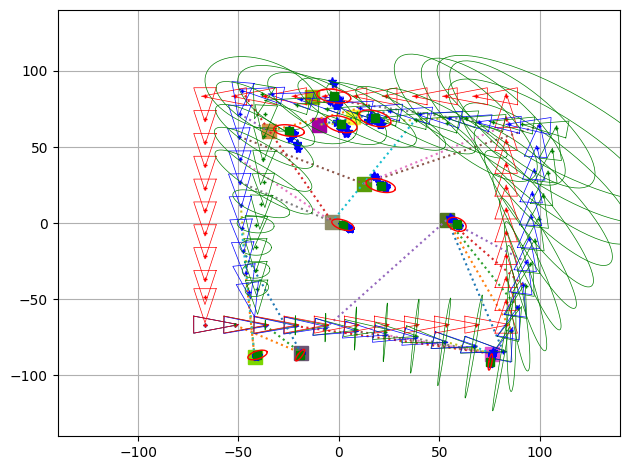

In [24]:
# TRY IT!

# Map configuration
n_features = 10
MapSize = 200

# Robot base characterization
SigmaX = 0.01 # Standard deviation in the x axis
SigmaY = 0.01 # Standard deviation in the y axins
SigmaTheta = 1.5*np.pi/180 # Bearing standar deviation
R = np.diag([SigmaX**2, SigmaY**2, SigmaTheta**2]) # Cov matrix

xRobot = np.vstack([-MapSize/3, -MapSize/3, 0.0])
robot = EFKSlamRobot(xRobot, R, n_features)

Sigma_r = 1.1
Sigma_theta = 5*np.pi/180
Q = np.diag([Sigma_r, Sigma_theta])**2 # Covariances for our very bad&expensive sensor (in the system <d,theta>)
fov = np.pi*2/3
max_range = 100

sensor = FOVSensor(Q, fov, max_range) 

demo_ekf_slam(robot, sensor, nFeatures=n_features, MapSize=MapSize, NONSTOP=True)


### Getting performance results

As with our previous contract, the managers ask for information about how well our EKF SLAM algorithm performs. For helping us in that mission, our colleagues have implemented a logger, which is meant to store some information each loop regarding the method performance and plot it at the end of its execution.

You will get an output similar to this:
  
  <table>
    <tr>
        <td><img src="images/fig7-1-2.png" width="300"></td>
        <td><img src="images/fig7-1-3.png" width="300"></td>
    </tr>
    <tr>
        <td><img src="images/fig7-1-4.png" width="300"></td>
        <td><img src="images/fig7-1-5.png" width="300"></td>
    <tr>
  </table>

In [25]:
class Logger():
    def __init__(self, nFeatures, nSteps):
        # Storage:
        self.PFeatDetStore = np.full((nFeatures,nSteps),np.Inf)
        self.FeatErrStore = np.full((nFeatures,nSteps),np.Inf)
        self.PXErrStore = np.full((nSteps,1), 0)
        self.XErrStore = np.full((2,nSteps), 0) # error in position and angle
        
    def log(self, k, robot, Map):
        
        # TODO
        IsMapped = robot.MappedFeatures[:,0] >= 0
        # Storage:
        for i in range(robot.MappedFeatures.shape[0]):
            if IsMapped[i]:
                ii = robot.MappedFeatures[i,:]
                xFeature = robot.xEst[ii[0]:ii[1]]
                self.PFeatDetStore[i,k] = np.linalg.det(robot.PEst[ii[0]:ii[1],ii[0]:ii[1]])
                self.FeatErrStore[i,k] = np.sqrt(np.sum((xFeature-Map[:,[i]])**2))
        self.PXErrStore[k,0] = linalg.det(robot.PEst[0:3,0:3])
        self.XErrStore[0,k] = np.sqrt(np.sum((robot.xEst[0:2]-robot.true_pose[0:2])**2))  # error in position and angle
        self.XErrStore[1,k] = abs(robot.xEst[2]-robot.true_pose[2])  # error in position and angle
        
    def draw(self, colors):
        nSteps = self.PFeatDetStore.shape[1]
        nFeatures = self.PFeatDetStore.shape[0]

        plt.figure()
        plt.figure(2) #hold on
        plt.title('Errors in robot localization')
        plt.plot(self.XErrStore[0,:],'b',label="Error in position")
        plt.plot(self.XErrStore[1,:],'r',label="Error in orientation")
        #plt.legend('Error in position','Error in orientation')
        plt.legend()

        plt.figure(3)# hold on
        plt.title('Determinant of the cov. matrix associated to the robot localization')
        xs = np.arange(nSteps)
        plt.plot(self.PXErrStore[:],'b')

        plt.figure(4)# hold on
        plt.title('Errors in features localization')

        plt.figure(5)# hold on
        plt.title('Log of the determinant of the cov. matrix associated to each feature')

        for i in range(nFeatures):
            plt.figure(5)
            h = plt.plot(np.log(self.PFeatDetStore[i,:]), color=colors[i,:])
            plt.figure(4)
            h = plt.plot(self.FeatErrStore[i,:], color=colors[i,:])

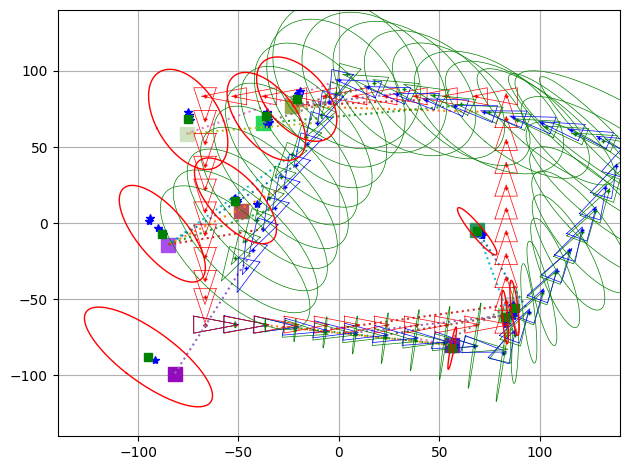

<Figure size 432x288 with 0 Axes>

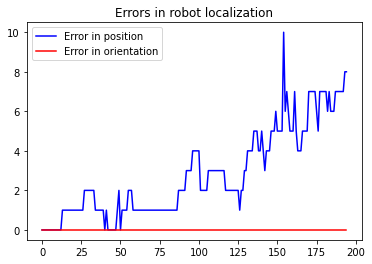

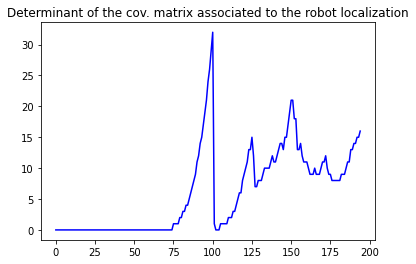

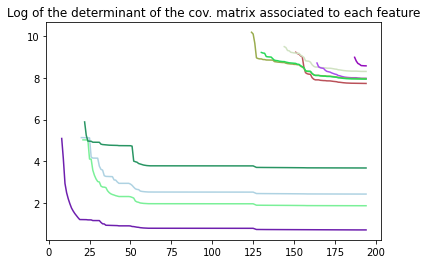

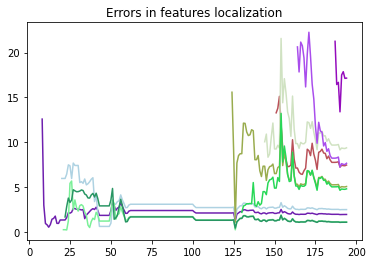

In [35]:
# Map configuration
n_features = 10
MapSize = 200

# Robot base characterization
SigmaX = 0.01 # Standard deviation in the x axis
SigmaY = 0.01 # Standard deviation in the y axins
SigmaTheta = 1.5*np.pi/180 # Bearing standar deviation
R = np.diag([SigmaX**2, SigmaY**2, SigmaTheta**2]) # Cov matrix

xRobot = np.vstack([-MapSize/3, -MapSize/3, 0.0])
robot = EFKSlamRobot(xRobot, R, n_features)

Sigma_r = 1.1
Sigma_theta = 5*np.pi/180
Q = np.diag([Sigma_r, Sigma_theta])**2 # Covariances for our very bad&expensive sensor (in the system <d,theta>)
fov = np.pi*2/3
max_range = 100

sensor = FOVSensor(Q, fov, max_range) 

demo_ekf_slam(robot, sensor, nFeatures=n_features, MapSize=MapSize, NONSTOP=True, LOG=True)

### <font color="blue"><b><i>Thinking about it (2)</i></b></font>

At this point you are able to **address the following points** (include some figures if needed):

- Why the uncertainty about the robot pose can increase between iterations?

    <p style="margin: 4px 0px 6px 5px; color:blue"><i>Si durante el trayecto que realiza el robot no se observa ningún landmark (durante un tiempo relativamente elevado) la incertidumbre de su pose irremediablemente crece. Como consecuencia de esto, cuando se realice otra observación a un landmark se propagará dicha incertidumbre a la posición del landmark en el mapa.</i></p>  
    
- Discuss the performance of our EKF SLAM implementation.

    <p style="margin: 4px 0px 6px 5px; color:blue"><i>Con las pruebas que he realizado, he podido ver que aunque nuestra implementación no proporcione estimaciones del todo exactas con la real, se aproxima bastante y, lo que es más importante, los errores que comete están dentro de la elipse de incertidumbre en todo momento. Esto también ocurre con los landmarks, por lo que "sabe" que puede haberse equivocado.</i></p>
    
Provide information about how the following parameters affect the SLAM algorithm:
    
- Different number of landmarks.

    <p style="margin: 4px 0px 6px 5px; color:blue"><i>Como es de esperar, a mayor número de landmarks peor se desenvolverá nuestro algoritmo (hay más incertidumbres a tener en cuenta) en términos de eficiencia computacional. Sin embargo, tener demasiados pocos landmarks puede hacer que el mapa y pose del robot estimado difieran bastante de la realidad (falta información para estimar correctamente). </i></p>

- Robot base characterization (standard deviations).

    <p style="margin: 4px 0px 6px 5px; color:blue"><i>Si tenemos una desviación típica demasiado alta, tendremos demasiada incertidumbre en el movimiento, por lo que la predicción podrá cambiar mucho con respecto a la real.</i></p>
    
- Sensor characterization.

    <p style="margin: 4px 0px 6px 5px; color:blue"><i>Si no tenemos un buen sensor que nos proporcione mediciones fiables, apaga y vámonos. Necesitamos un sensor suficientemente preciso para hacer que nuestro mapa no tenga incertidumbres en los landmarks y pose del robot que no sean posibles de evitar de ninguna manera (ni algoritmos ni nada) ya que las mediciones tengan asociada demasiada incertidumbre.</i></p>    
    